# Expanding a Mexican-Food restaurant franchise


In [2]:
import pandas as pd
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import geopandas as gpd

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


#### Import postal code data of Toronto

In [3]:
toronto_pc = pd.read_csv('toronto_postal_code.csv')
toronto_pc.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [4]:
toronto_pc = toronto_pc[toronto_pc.Borough !='Not assigned' ]
toronto_pc.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


#### Attaching geo-data

In [5]:
toronto_geo = pd.read_csv('Geospatial_Coordinates.csv')
toronto_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
toronto_df = pd.merge(toronto_pc, toronto_geo, how='right', on=['Postal Code'])
toronto_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


demographic data

#### Attaching ward data

In [7]:
from shapely.geometry import *
df = gpd.read_file("WARD_WGS84.shp")
df.head()

,AREA_ID,AREA_TYPE,AREA_S_CD,AREA_L_CD,AREA_NAME,X,Y,LONGITUDE,LATITUDE,geometry
0,2551040,WD18,16,16,Don Valley East,318237.290,4844000.0,-79.33298,43.739716,"POLYGON ((-79.31335 43.71699, -79.31950 43.715..."
1,2551044,WD18,03,03,Etobicoke-Lakeshore,303099.474,4831000.0,-79.52087,43.621646,"POLYGON ((-79.49777 43.65198, -79.49725 43.651..."
2,2551048,WD18,15,15,Don Valley West,314825.876,4843000.0,-79.37536,43.728396,"POLYGON ((-79.35232 43.71573, -79.35209 43.715..."
3,2551052,WD18,23,23,Scarborough North,324522.149,4852000.0,-79.25467,43.809672,"POLYGON ((-79.22591 43.83960, -79.22556 43.839..."
4,2551056,WD18,11,11,University-Rosedale,313306.543,4837000.0,-79.39432,43.671139,"POLYGON ((-79.39004 43.69050, -79.39004 43.690..."


Define a function that returns the ward to which a coordinate belongs

In [8]:
def findWardByGeo(point):
    for poly, ward in zip(df['geometry'], df['AREA_NAME']):             
        if poly.intersects(point) == True:
           return ward;
    return 'Not Ward'
        
        

In [9]:
toronto_df['ward_name'] = toronto_df.apply(lambda x: findWardByGeo( Point(x['Longitude'], x['Latitude'])), axis=1)

toronto_df = toronto_df[toronto_df.ward_name != 'No Ward']
toronto_df.head()


,Postal Code,Borough,Neighbourhood,Latitude,Longitude,ward_name
0,M3A,North York,Parkwoods,43.753259,-79.329656,Don Valley East
1,M4A,North York,Victoria Village,43.725882,-79.315572,Don Valley East
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Toronto Centre
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Eglinton-Lawrence
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,University-Rosedale


#### Import income data by ward

In [10]:
toronto_income = pd.read_csv('average_income_ward_toronto.csv')
toronto_income.head()


,ward,ward_name,income_median
0,Ward 1,Etobicoke North,61169
1,Ward 2,Etobicoke Centre,82870
2,Ward 3,Etobicoke-Lakeshore,71859
3,Ward 4,Parkdale-High Park,65546
4,Ward 5,York South-Weston,53469


In [11]:
toronto_income.describe()

,income_median
count,25.000000
mean,66536.480000
std,9711.604777
min,51204.000000
25%,60064.000000
50%,65546.000000
75%,70920.000000
max,87360.000000


### Visualice the distribution  of income

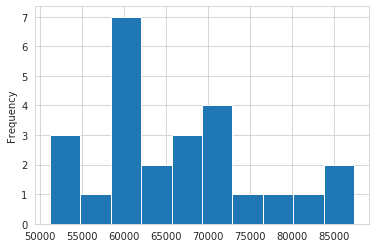

In [12]:
import seaborn as sns
sns.set_style('whitegrid')
toronto_income['income_median'].plot(kind='hist')

### Discretize data

In [13]:
#we discretize into 3 categories, namely, low, medium and high
bin_labels_3 = [1, 2, 3]

toronto_income['income_class'] =   pd.cut(toronto_income['income_median'],
                              bins =3,
                              labels=bin_labels_3)
toronto_income.head()

,ward,ward_name,income_median,income_class
0,Ward 1,Etobicoke North,61169,1
1,Ward 2,Etobicoke Centre,82870,3
2,Ward 3,Etobicoke-Lakeshore,71859,2
3,Ward 4,Parkdale-High Park,65546,2
4,Ward 5,York South-Weston,53469,1


Resulting dataset with data that associates postal codes, neighbourhoods, location, ward, and income

In [14]:
toronto_df = pd.merge(toronto_df, toronto_income, how='right', on=['ward_name'])
toronto_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,ward_name,ward,income_median,income_class
0,M3A,North York,Parkwoods,43.753259,-79.329656,Don Valley East,Ward 16,60673,1
1,M4A,North York,Victoria Village,43.725882,-79.315572,Don Valley East,Ward 16,60673,1
2,M3B,North York,Don Mills,43.745906,-79.352188,Don Valley East,Ward 16,60673,1
3,M3C,North York,Don Mills,43.725900,-79.340923,Don Valley East,Ward 16,60673,1
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Toronto Centre,Ward 13,51204,1


In [15]:
toronto_df.drop(['ward', 'income_median'], axis=1, inplace=True)
toronto_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,ward_name,income_class
0,M3A,North York,Parkwoods,43.753259,-79.329656,Don Valley East,1
1,M4A,North York,Victoria Village,43.725882,-79.315572,Don Valley East,1
2,M3B,North York,Don Mills,43.745906,-79.352188,Don Valley East,1
3,M3C,North York,Don Mills,43.725900,-79.340923,Don Valley East,1
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Toronto Centre,1


In [16]:
toronto_df = toronto_df.dropna()
toronto_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,ward_name,income_class
0,M3A,North York,Parkwoods,43.753259,-79.329656,Don Valley East,1
1,M4A,North York,Victoria Village,43.725882,-79.315572,Don Valley East,1
2,M3B,North York,Don Mills,43.745906,-79.352188,Don Valley East,1
3,M3C,North York,Don Mills,43.725900,-79.340923,Don Valley East,1
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Toronto Centre,1


### After associating neighbourhoods to ward income data, we obtain venues information from foursquare.

##### We setup foursquare api credentials

In [17]:
CLIENT_ID = '3JLYRNPRDDRYZM2V5MQKADJGSQNVDRIHGVH5ULAFWLFB2YXE' # your Foursquare ID
CLIENT_SECRET = 'K5VFXUANQX520NLXQEMLWUQZ5CMCAZMHJSXIZUGOMVS2G2JO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3JLYRNPRDDRYZM2V5MQKADJGSQNVDRIHGVH5ULAFWLFB2YXE
CLIENT_SECRET:K5VFXUANQX520NLXQEMLWUQZ5CMCAZMHJSXIZUGOMVS2G2JO


#### We call the api to get venues for one neighbourhood

In [18]:
neighborhood_latitude = 43.679557 # neighborhood latitude value
neighborhood_longitude = -79.352188 # neighborhood longitude value

neighborhood_name = 'The Danforth West, Riverdale' # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of The Danforth West, Riverdale are 43.679557, -79.352188.


#### Now, let's get the top 100 venues that are in Parkwoods within a radius of 500 meters.

In [19]:
LIMIT = 100 
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=3JLYRNPRDDRYZM2V5MQKADJGSQNVDRIHGVH5ULAFWLFB2YXE&client_secret=K5VFXUANQX520NLXQEMLWUQZ5CMCAZMHJSXIZUGOMVS2G2JO&v=20180605&ll=43.679557,-79.352188&radius=500&limit=100'

In [20]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fe256fad5239e00e252056c'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Greektown',
  'headerFullLocation': 'Greektown, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 43,
  'suggestedBounds': {'ne': {'lat': 43.684057004500005,
    'lng': -79.34597738332336},
   'sw': {'lat': 43.6750569955, 'lng': -79.35839861667664}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bce4183ef10952197da8386',
       'name': 'Pantheon',
       'location': {'address': '407 Danforth Ave.',
        'crossStreet': 'at Chester Ave.',
        'lat': 43.67762124481265,
        'lng': -79.35143390043564,
        'labeledLatLngs': [{'label':

We repeat the process for every neighbourhood in the dataset. First, we create a function that extracts the category of the venue from the resultset.

In [21]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Let's try with the example above:

In [22]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/rene/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Pantheon,Greek Restaurant,43.677621,-79.351434
1,MenEssentials,Cosmetics Shop,43.677820,-79.351265
2,Cafe Fiorentina,Italian Restaurant,43.677743,-79.350115
3,La Diperie,Ice Cream Shop,43.677702,-79.352265
4,Dolce Gelato,Ice Cream Shop,43.677773,-79.351187


In [23]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

43 venues were returned by Foursquare.


In [24]:
toronto_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,ward_name,income_class
0,M3A,North York,Parkwoods,43.753259,-79.329656,Don Valley East,1
1,M4A,North York,Victoria Village,43.725882,-79.315572,Don Valley East,1
2,M3B,North York,Don Mills,43.745906,-79.352188,Don Valley East,1
3,M3C,North York,Don Mills,43.725900,-79.340923,Don Valley East,1
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Toronto Centre,1


In [25]:
toronto_income_only= toronto_df[['Neighbourhood','income_class']]
toronto_income_only.rename(columns={"Neighbourhood": "Neighborhood"},inplace=True)
toronto_income_only.head()

/home/rene/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Neighborhood,income_class
0,Parkwoods,1
1,Victoria Village,1
2,Don Mills,1
3,Don Mills,1
4,"Regent Park, Harbourfront",1


We create a function that iterates over the toronto dataset, hence creating a vector with the returned venues

In [26]:
def getNearbyVenues(names, latitudes, longitudes, ward_class, radius=500):
    print('Obtaining venues data from api, please wait...')
    venues_list=[]
    nearby_venues_df = pd.DataFrame()
    
    
    for name, lat, lng, ward_income_class in zip(names, latitudes, longitudes, ward_class):   
        try:  
            print(name,lat,lng)    
            # create the API request URL

            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                    CLIENT_ID, 
                    CLIENT_SECRET, 
                    VERSION, 
                    lat, 
                    lng, 
                    radius, 
                    LIMIT)

            # make the GET request
            results = requests.get(url).json()     
            venues = results['response']['groups'][0]['items']       

            ##start          

            nearby_venues = pd.json_normalize(venues) # flatten JSON

            # filter columns
            filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
            nearby_venues =nearby_venues.loc[:, filtered_columns]
            # filter the category for each row
            nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
            # clean columns
            nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

            nearby_venues['Neighborhood']=name
            nearby_venues['Neighborhood Latitude']=lat
            nearby_venues['Neighborhood Longitude']=lng
            nearby_venues['Income Class']=ward_income_class

            #print(nearby_venues)
            #print(nearby_venues['categories'])

            ##end             

            nearby_venues_df = nearby_venues_df.append(nearby_venues)   
        except:
            print('error')
            print(nearby_venues)
    

    print('For... finished')
    
    nearby_venues_df.columns = ['Venue', 
                  'Venue Category',
                  'Venue Latitude', 
                  'Venue Longitude',                   
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Income Class'           
                  ]
   
    #print(nearby_venues_df.head())
    #print(nearby_venues_df.shape)
    print('Done...')
    
    return(nearby_venues_df)

In [27]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighbourhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude'],
                                   ward_class=toronto_df['income_class']
                                  )
#print(toronto_venues.head())
print(toronto_venues.shape)

Obtaining venues data from api, please wait...
Parkwoods 43.7532586 -79.3296565
Victoria Village 43.725882299999995 -79.31557159999998
Don Mills 43.745905799999996 -79.352188
Don Mills 43.72589970000001 -79.340923
Regent Park, Harbourfront 43.6542599 -79.3606359
Garden District, Ryerson 43.6571618 -79.37893709999999
St. James Town 43.6514939 -79.3754179
Commerce Court, Victoria Hotel 43.6481985 -79.37981690000001
St. James Town, Cabbagetown 43.667967 -79.3676753
Church and Wellesley 43.6658599 -79.38315990000001
Lawrence Manor, Lawrence Heights 43.718517999999996 -79.46476329999999
Glencairn 43.709577 -79.44507259999999
Bedford Park, Lawrence Manor East 43.7332825 -79.4197497
Roselawn 43.7116948 -79.41693559999999
North Toronto West, Lawrence Park 43.7153834 -79.40567840000001
Queen's Park, Ontario Provincial Government 43.6623015 -79.3894938
Central Bay Street 43.6579524 -79.3873826
Christie 43.669542 -79.4225637
The Annex, North Midtown, Yorkville 43.6727097 -79.40567840000001
Univer

##### How many neighbourhoods in the dataset

In [28]:
toronto_venues.groupby('Neighborhood').count()

,Venue,Venue Category,Venue Latitude,Venue Longitude,Neighborhood Latitude,Neighborhood Longitude,Income Class
Neighborhood,,,,,,,
Agincourt,5,5,5,5,5,5,5
"Alderwood, Long Branch",8,8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",20,20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24,24
Berczy Park,57,57,57,57,57,57,57
"Birch Cliff, Cliffside West",4,4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22,22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",14,14,14,14,14,14,14


##### How many unique categories in the dataset

In [29]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 267 uniques categories.


## Cluster analysis

Wrangling columns before running cluster algorithms

In [63]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
#fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])

#toronto_onehot = toronto_onehot[fixed_columns]



toronto_onehot.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [64]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.00,0.0,0.0,0.0,0.0,

In [65]:
toronto_grouped.shape

(90, 267)

In [66]:
toronto_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.00,0.0,0.0,0.0,0.0,

#### Let's print each neighborhood along with the top 5 most common venues

In [67]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0               Skating Rink   0.2
1                     Lounge   0.2
2             Clothing Store   0.2
3             Breakfast Spot   0.2
4  Latin American Restaurant   0.2


----Alderwood, Long Branch----
          venue  freq
0   Pizza Place  0.25
1   Coffee Shop  0.12
2  Dance Studio  0.12
3           Pub  0.12
4  Skating Rink  0.12


----Bathurst Manor, Wilson Heights, Downsview North----
          venue  freq
0   Coffee Shop  0.10
1          Bank  0.10
2         Diner  0.05
3    Restaurant  0.05
4  Intersection  0.05


----Bayview Village----
                 venue  freq
0  Japanese Restaurant  0.25
1                 Café  0.25
2                 Bank  0.25
3   Chinese Restaurant  0.25
4                Motel  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0      Sandwich Place  0.08
1         Pizza Place  0.08
2  Italian Restaurant  0.08
3         Coffee Shop  0.08
4           Pet Store  0.04


---

                           venue  freq
0                           Café  0.08
1  Vegetarian / Vegan Restaurant  0.07
2                    Coffee Shop  0.07
3             Mexican Restaurant  0.05
4          Vietnamese Restaurant  0.05


----Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens----
                   venue  freq
0         Sandwich Place  0.25
1                   Park  0.25
2               Bus Line  0.25
3            Pizza Place  0.25
4  Performing Arts Venue  0.00


----Lawrence Manor, Lawrence Heights----
                    venue  freq
0          Clothing Store  0.23
1  Furniture / Home Store  0.23
2                Boutique  0.08
3   Vietnamese Restaurant  0.08
4              Shoe Store  0.08


----Lawrence Park----
               venue  freq
0        Swim School  0.25
1           Bus Line  0.25
2               Park  0.25
3   Business Service  0.25
4  Accessories Store  0.00


----Leaside----
                    venue  freq
0             Coffee Shop  

                       venue  freq
0                Pizza Place  0.25
1                Coffee Shop  0.25
2      Portuguese Restaurant  0.25
3               Hockey Arena  0.25
4  Middle Eastern Restaurant  0.00


----Westmount----
                       venue  freq
0                Pizza Place  0.25
1         Chinese Restaurant  0.12
2  Middle Eastern Restaurant  0.12
3             Discount Store  0.12
4             Sandwich Place  0.12


----Wexford, Maryvale----
                       venue  freq
0             Sandwich Place  0.17
1  Middle Eastern Restaurant  0.17
2                Auto Garage  0.17
3                     Bakery  0.17
4      Vietnamese Restaurant  0.17


----Willowdale, Newtonbrook----
                             venue  freq
0                             Park   1.0
1                Accessories Store   0.0
2                    Metro Station   0.0
3  Molecular Gastronomy Restaurant   0.0
4       Modern European Restaurant   0.0


----Willowdale, Willowdale East----
    

Let's write a function to sort the venues in descending order.

In [68]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood

In [69]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Clothing Store,Skating Rink,Lounge,Latin American Restaurant,Eastern European Restaurant,Drugstore,Donut Shop,Electronics Store,Department Store
1,"Alderwood, Long Branch",Pizza Place,Gym,Skating Rink,Pub,Dance Studio,Sandwich Place,Coffee Shop,General Travel,Creperie,German Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Middle Eastern Restaurant,Sandwich Place,Ice Cream Shop,Sushi Restaurant,Supermarket,Mobile Phone Shop,Intersection,Deli / Bodega
3,Bayview Village,Chinese Restaurant,Café,Japanese Restaurant,Bank,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Yoga Studio
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Pizza Place,Café,Pharmacy,Juice Bar,Indian Restaurant,Restaurant,Sushi Restaurant


In [70]:
toronto_grouped = pd.merge(left=toronto_grouped, right=toronto_income_only, left_on='Neighborhood', right_on='Neighborhood') 
toronto_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,income_class
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.00,0.0

Running cluster algorithm

In [71]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
print(toronto_grouped_clustering.shape)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 


(94, 267)


array([0, 0, 1, 0, 2, 2, 1, 0, 0, 2, 0, 1, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 2, 0, 2, 1, 2, 1, 1, 2, 0, 0, 1, 1, 0, 1, 0,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0,
       2, 2, 0, 1, 3, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 2, 2, 0, 1, 2, 1, 1,
       1, 1, 1, 0, 2, 2], dtype=int32)

In [72]:
print(kmeans.labels_.shape)
print(neighborhoods_venues_sorted.shape)


(94,)
(90, 11)


In [73]:
toronto_df.rename(columns={"Neighbourhood": "Neighborhood"}, inplace=True)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [74]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_[0:90])

print(neighborhoods_venues_sorted.head())

toronto_geo = toronto_df[['Neighborhood','Latitude','Longitude','income_class']]
neighborhoods_venues_sorted.set_index('Neighborhood')
print('geo***********')
print(toronto_geo.head())


toronto_merged = pd.merge(left=neighborhoods_venues_sorted, right=toronto_geo, left_on='Neighborhood', right_on='Neighborhood') 


# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
#toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head() # check the last columns!

   Cluster Labels                                     Neighborhood  \
0               0                                        Agincourt   
1               0                           Alderwood, Long Branch   
2               1  Bathurst Manor, Wilson Heights, Downsview North   
3               0                                  Bayview Village   
4               2                Bedford Park, Lawrence Manor East   

  1st Most Common Venue 2nd Most Common Venue      3rd Most Common Venue  \
0        Breakfast Spot        Clothing Store               Skating Rink   
1           Pizza Place                   Gym               Skating Rink   
2           Coffee Shop                  Bank  Middle Eastern Restaurant   
3    Chinese Restaurant                  Café        Japanese Restaurant   
4           Coffee Shop        Sandwich Place         Italian Restaurant   

  4th Most Common Venue      5th Most Common Venue  \
0                Lounge  Latin American Restaurant   
1             

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude,income_class
0,0,Agincourt,Breakfast Spot,Clothing Store,Skating Rink,Lounge,Latin American Restaurant,Eastern European Restaurant,Drugstore,Donut Shop,Electronics Store,Department Store,43.794200,-79.262029,2
1,0,"Alderwood, Long Branch",Pizza Place,Gym,Skating Rink,Pub,Dance Studio,Sandwich Place,Coffee Shop,General Travel,Creperie,German Restaurant,43.602414,-79.543484,2
2,1,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Middle Eastern Restaurant,Sandwich Place,Ice Cream Shop,Sushi Restaurant,Supermarket,Mobile Phone Shop,Intersection,Deli / Bodega,43.754328,-79.442259,1
3,0,Bayview Village,Chinese Restaurant,Café,Japanese Restaurant,Bank,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Yoga Studio,43.786947,-79.385975,2
4,2,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Pizza Place,Café,Pharmacy,Juice Bar,Indian Restaurant,Restaurant,Sushi Restaurant,43.733283,-79.419750,3


In [75]:
toronto_merged['Cluster Labels']=toronto_merged['Cluster Labels'].fillna(0.0).astype(int)
toronto_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude,income_class
0,0,Agincourt,Breakfast Spot,Clothing Store,Skating Rink,Lounge,Latin American Restaurant,Eastern European Restaurant,Drugstore,Donut Shop,Electronics Store,Department Store,43.794200,-79.262029,2
1,0,"Alderwood, Long Branch",Pizza Place,Gym,Skating Rink,Pub,Dance Studio,Sandwich Place,Coffee Shop,General Travel,Creperie,German Restaurant,43.602414,-79.543484,2
2,1,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Middle Eastern Restaurant,Sandwich Place,Ice Cream Shop,Sushi Restaurant,Supermarket,Mobile Phone Shop,Intersection,Deli / Bodega,43.754328,-79.442259,1
3,0,Bayview Village,Chinese Restaurant,Café,Japanese Restaurant,Bank,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Yoga Studio,43.786947,-79.385975,2
4,2,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Pizza Place,Café,Pharmacy,Juice Bar,Indian Restaurant,Restaurant,Sushi Restaurant,43.733283,-79.419750,3


## Finally, let's visualize the resulting clusters


In [76]:
address = 'Toronto, CAN'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.7570209, -79.3526399.


In [77]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Analysis of Clusters

#### Cluster 1

In [53]:
cluster1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0,14] + list(range(1, toronto_merged.shape[1]-3))]]
cluster1

,Cluster Labels,income_class,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,2,Agincourt,Breakfast Spot,Clothing Store,Skating Rink,Lounge,Latin American Restaurant,Eastern European Restaurant,Drugstore,Donut Shop,Electronics Store,Department Store
1,0,2,"Alderwood, Long Branch",Pizza Place,Gym,Skating Rink,Pub,Dance Studio,Sandwich Place,Coffee Shop,General Travel,Creperie,German Restaurant
3,0,2,Bayview Village,Chinese Restaurant,Café,Japanese Restaurant,Bank,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Yoga Studio
7,0,2,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Gym,Furniture / Home Store,Burrito Place,Stadium,Italian Restaurant,Intersection,Bar
8,0,2,"Business reply mail Processing Centre, South C...",Gym / Fitness Center,Garden,Pizza Place,Comic Shop,Restaurant,Burrito Place,Brewery,Skate Park,Light Rail Station,Farmers Market
10,0,2,Caledonia-Fairbanks,Park,Women's Store,Pool,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
12,0,2,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Burger Joint,Salad Place,Thai Restaurant,Bubble Tea Shop,Bar,Art Museum
13,0,2,Christie,Grocery Store,Café,Park,Nightclub,Italian Restaurant,Baby Store,Athletics & Sports,Candy Store,Restaurant,Coffee Shop
31,0,3,"First Canadian Place, Underground city",Coffee Shop,Café,Hotel,Gym,Japanese Restaurant,Restaurant,Asian Restaurant,Seafood Restaurant,American Restaurant,Steakhouse
32,0,1,"Garden District, Ryerson",Coffee Shop,Clothing Store,Café,Hotel,Middle Eastern Restaurant,Cosmetics Shop,Japanese Restaurant,Italian Restaurant,Bubble Tea Shop,Diner


#### Cluster 2

In [78]:
cluster2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0,14] + list(range(1, toronto_merged.shape[1]-3))]]
cluster2

,Cluster Labels,income_class,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,1,1,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Middle Eastern Restaurant,Sandwich Place,Ice Cream Shop,Sushi Restaurant,Supermarket,Mobile Phone Shop,Intersection,Deli / Bodega
6,1,1,"Birch Cliff, Cliffside West",General Entertainment,College Stadium,Café,Skating Rink,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
11,1,1,Cedarbrae,Caribbean Restaurant,Bakery,Hakka Restaurant,Athletics & Sports,Thai Restaurant,Bank,Gas Station,Fried Chicken Joint,Yoga Studio,Dim Sum Restaurant
14,1,1,Church and Wellesley,Japanese Restaurant,Coffee Shop,Sushi Restaurant,Gay Bar,Restaurant,Yoga Studio,Café,Fast Food Restaurant,Men's Store,Mediterranean Restaurant
15,1,1,"Clarks Corners, Tam O'Shanter, Sullivan",Fast Food Restaurant,Pizza Place,Pharmacy,Chinese Restaurant,Italian Restaurant,Bank,Thai Restaurant,Convenience Store,Gas Station,Fried Chicken Joint
16,1,1,"Cliffside, Cliffcrest, Scarborough Village West",Motel,Movie Theater,American Restaurant,Yoga Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
17,1,1,"Commerce Court, Victoria Hotel",Coffee Shop,Restaurant,Café,Hotel,Italian Restaurant,Gym,Deli / Bodega,Seafood Restaurant,Japanese Restaurant,American Restaurant
19,1,1,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",Coffee Shop,Discount Store,Sandwich Place,Convenience Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center,Dance Studio
20,1,1,Don Mills,Gym,Restaurant,Coffee Shop,Japanese Restaurant,Beer Store,Art Gallery,Caribbean Restaurant,Sushi Restaurant,Baseball Field,Shopping Mall
21,1,1,Don Mills,Gym,Restaurant,Coffee Shop,Japanese Restaurant,Beer Store,Art Gallery,Caribbean Restaurant,Sushi Restaurant,Baseball Field,Shopping Mall


#### Cluster 3

In [79]:
cluster3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0,14] + list(range(1, toronto_merged.shape[1]-3))]]
cluster3

,Cluster Labels,income_class,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,2,3,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Pizza Place,Café,Pharmacy,Juice Bar,Indian Restaurant,Restaurant,Sushi Restaurant
5,2,3,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Pharmacy,Farmers Market,Beer Bar,Cheese Shop,Bakery,Restaurant,Breakfast Spot
9,2,3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Airport Lounge,Plane,Sculpture Garden,Bar,Harbor / Marina,Boat or Ferry,Rental Car Location,Airport Gate
18,2,3,Davisville North,Gym / Fitness Center,Breakfast Spot,Department Store,Sandwich Place,Hotel,Food & Drink Shop,Dance Studio,Park,Doner Restaurant,Dog Run
33,2,3,Glencairn,Pub,Park,Bakery,Japanese Restaurant,Yoga Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
35,2,1,"Guildwood, Morningside, West Hill",Electronics Store,Restaurant,Rental Car Location,Mexican Restaurant,Breakfast Spot,Medical Center,Bank,Discount Store,Dim Sum Restaurant,Diner
37,2,2,"High Park, The Junction South",Mexican Restaurant,Café,Thai Restaurant,Arts & Crafts Store,Grocery Store,Flea Market,Bakery,Cajun / Creole Restaurant,Italian Restaurant,Fried Chicken Joint
40,2,1,"Humberlea, Emery",Baseball Field,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Yoga Studio,Falafel Restaurant
48,2,3,"Little Portugal, Trinity",Bar,Vietnamese Restaurant,Asian Restaurant,Restaurant,Men's Store,Vegetarian / Vegan Restaurant,Café,Coffee Shop,Diner,Ice Cream Shop
49,2,3,"Malvern, Rouge",Fast Food Restaurant,Yoga Studio,Deli / Bodega,Escape Room,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run


#### Cluster 4

In [80]:
cluster4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[0,14] + list(range(1, toronto_merged.shape[1]-3))]]
cluster4

,Cluster Labels,income_class,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


## Results

By running the algorithm using different values of k, we noticed that any value greater than three resulted in 3 distinct clusters. Interestingly, this number of clusters also corresponds to the number of bins on the income variable.

Moreover, we can see that most of the international-food venues, are concentrated in a small area, namely, in the center of the city, which also happens to be one of the areas with the highest income-per-familiy.

By analysing this data, investors decided to open a new restaurant in the area of Toronto Dominion Centre, because there are several international restaurants surrounded by wards with high income.